In [1]:
import sys
# setting path
sys.path.append('../../')

import os
import re
import numpy as np
import matplotlib.pyplot as plt
import copy
from argparse import ArgumentParser

from Models.MainModel import *
from Models.Losses import *

from Utilities.Utilities import ReadYaml, SerializeObjects, DeserializeObjects, LoadModelConfigs, LoadParams
from tqdm import trange, tqdm
import itertools
from scipy.stats import mode
import pandas as pd
import matplotlib.pyplot as plt

## GPU selection
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

# TensorFlow wizardry
config = tf.compat.v1.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 1.0
# Create a session with the above options specified.
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))         

In [2]:
Test1 = pd.read_excel('./Data/data.xlsx', sheet_name='test1').values[:,1]
Test2 = pd.read_excel('./Data/data.xlsx', sheet_name='test2').values[:,1]
Test3 = pd.read_excel('./Data/data.xlsx', sheet_name='test3').values[:,1]
Test4 = pd.read_excel('./Data/data.xlsx', sheet_name='test4').values[:,1]

RhythmicData = pd.read_csv('./Data/RhythmicData.csv').values
DataSize=len(RhythmicData) 

'''
SigDim = len(Test4)
CompSize = 130
FiltLen = (SigDim - CompSize)//2 + 1
'''




'\nSigDim = len(Test4)\nCompSize = 130\nFiltLen = (SigDim - CompSize)//2 + 1\n'

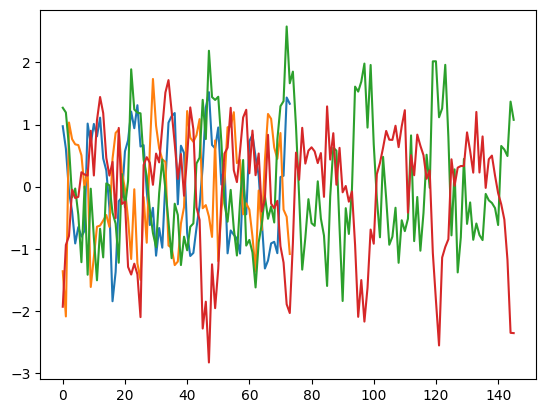

In [3]:
plt.plot(Test1)
plt.plot(Test2)
plt.plot(Test3)
plt.plot(Test4)

In [3]:
SigDim = RhythmicData.shape[-1]
CompSize = 10
FiltLen = (SigDim - CompSize)//2 + 1

LatDim = 10
MaskingRate = 0
FcLimit = 1.
SlidingSize= 1
ReparaStd = 0.1 
Reparam = True

#FCs = np.random.rand(6)[None]
FCs = np.zeros((1, 6)) + 0.05
Inputs = RhythmicData
FCs = np.tile(FCs, (Inputs.shape[0],1))

In [38]:
EncModel = Encoder(SigDim=SigDim,SlidingSize=SlidingSize, LatDim= LatDim, Type = '', Reparam=True, FcLimit=FcLimit)
FeatExtModel = FeatExtractor(SigDim=SigDim, CompSize = CompSize)
FeatGenModel = FeatGenerator(SigDim=SigDim,SlidingSize=SlidingSize,CompSize= CompSize, LatDim= LatDim)
ReconModel = Reconstructor(SigDim=SigDim, CompSize= CompSize, SlidingSize=SlidingSize)

PredHH , PredHL, PredLH, PredLL = FeatExtModel.predict([Inputs,FCs])

713/713 [==============================] - 1s 724us/step


In [42]:
SigDim, SlidingSize, CompSize

(13, 1, 10)

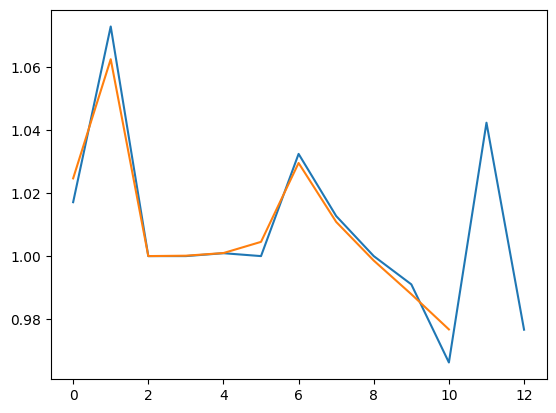

In [31]:
idx = 2
plt.plot(Inputs[idx])
plt.plot(PredLL[idx])

In [4]:
def MaskingGen ( InpRegul, MaskingRate, MaskStd):
    ## Masking vector generation 1 vs 0
    NBatch = tf.shape(InpRegul)[0]
    
    MaskIDX = tf.random.shuffle(tf.range(NBatch * InpRegul.shape[1] ))
    CutIDX = tf.cast(  tf.cast(tf.shape(MaskIDX)[0], dtype=tf.float32) * (1-MaskingRate), dtype=tf.int32 )
    MaskIDX = tf.cast(MaskIDX < CutIDX, dtype=tf.float32)
    MaskVec = tf.reshape(MaskIDX, (NBatch, -1))[:,:,None]
    
    ## Noise vector generation 1 vs 0; Enocder 에서는 masking {0 vs 1}을 통해 BP가 되지 않도록 제어; Filtering (feature extracting) part에서는 encoder에서 masking 된 부분에 noise를 추가해줌
    RevMaskIDX = MaskIDX == 0
    RevMaskIDX = tf.cast(RevMaskIDX, dtype=tf.float32)
    NoisVec = RevMaskIDX * tf.random.normal(tf.shape(RevMaskIDX), stddev=MaskStd)
    NoisVec = tf.reshape(NoisVec, (NBatch, -1))[:,:,None]
    return MaskVec, NoisVec


def GenLowFilter (LF, N, Decay=0.):
    nVec = np.arange(N, dtype=np.float32)
    Window = tf.signal.hamming_window(N)

    # A low-pass filter
    X = 2 * LF * (nVec - (N - 1) / 2)
    X = tf.where(X == 0, 1e-7, X)
    LPF = tf.sin(np.pi*X)/(np.pi*X)
    LPF *= Window
    LPF /= tf.reduce_sum(LPF, axis=-1, keepdims=True)
    
    # Freq cutoff Decay effect
    if Decay != 0:
        LPF *= tf.exp(-Decay * nVec) 
        #LPF *= tf.exp(-LF * Decay * nVec) 
        
    
    return LPF[:,None] 


def GenHighFilter (HF, N, Decay=0.):
    nVec = np.arange(N, dtype=np.float32)
    Window = tf.signal.hamming_window(N)

    # A high-pass filter
    Y = 2 * HF * (nVec - (N - 1) / 2)
    Y = tf.where(Y == 0, 1e-7, Y)
    HPF = tf.sin(np.pi*Y)/(np.pi*Y)
    HPF *= Window
    HPF /= tf.reduce_sum(HPF, axis=-1, keepdims=True)
    HPF = -HPF

    ## To make HPF[(N - 1) // 2] += 1
    Mask = np.zeros(HPF.shape[1])
    Mask[(N - 1) // 2] += 1
    Mask = tf.constant(Mask, dtype=tf.float32)
    HPF = HPF + Mask
    
    # Freq cutoff Decay effect
    if Decay != 0:
        HPF *= tf.exp(-Decay * nVec) 
        #HPF *= tf.exp(-HF * Decay * nVec) 
    
    return HPF[:,None] 

In [5]:
def Encoder(SigDim, SlidingSize = 50, LatDim= 2, Type = '', ReparaStd = 0.1 , Reparam = False, FcLimit=0.05):

    InpL = Input(shape=(SigDim,), name='Inp_Enc')
    InpFrame = tf.signal.frame(InpL, SlidingSize, SlidingSize)

   
    Encoder = Bidirectional(GRU(5, return_sequences=True))(InpFrame)
    Encoder = Bidirectional(GRU(10, return_sequences=False))(Encoder)
    Encoder = Dense(10, activation='relu')(Encoder)
    Encoder = Dense(10, activation='relu')(Encoder)
    
    Z_Mu = Dense(LatDim, activation='linear', name='Z_Mu')(Encoder)
    Z_Log_Sigma = Dense(LatDim, activation='softplus')(Encoder)
    Z_Log_Sigma = ReName(Z_Log_Sigma,'Z_Log_Sigma')
    
    
    # Reparameterization Trick for sampling from Guassian distribution
    Epsilon = tf.random.normal(shape=(tf.shape(Z_Mu)[0], Z_Mu.shape[1]), mean=0., stddev=ReparaStd)
    
    if Reparam==False:
        Epsilon = Epsilon * 0
    
    Zs = Z_Mu + tf.exp(0.5 * Z_Log_Sigma) * Epsilon
    Zs = ReName(Zs,'Zs')
    
    FC_Mu =   Dense(6, activation='relu')(Encoder)
    FC_Mu =   Dense(6, activation='sigmoid')(FC_Mu)
    FC_Mu = tf.clip_by_value(FC_Mu, 1e-7, 1-1e-7)
    FC_Mu = ReName(FC_Mu,'FC_Mu')
    
    # Reparameterization Trick for sampling from Uniformly distribution; ϵ∼U(0,1) 
    Epsilon = tf.random.uniform(shape=(tf.shape(FC_Mu)[0], FC_Mu.shape[1]))
    Epsilon = tf.clip_by_value(Epsilon, 1e-7, 1-1e-7)
    
    LogEps = tf.math.log(Epsilon)
    LogNegEps = tf.math.log(1 - Epsilon)
    
    LogTheta = tf.math.log(FC_Mu)
    LogNegTheta = tf.math.log(1-FC_Mu)
    
    if Reparam==True:
        FCs = tf.math.sigmoid(LogEps - LogNegEps + LogTheta - LogNegTheta) * 1. + FC_Mu * 0.
    else:
        FCs = tf.math.sigmoid(LogEps - LogNegEps + LogTheta - LogNegTheta) * 0. + FC_Mu * 1.
    
    FCs = FCs * FcLimit
    FCs = tf.clip_by_value(FCs, 1e-7, FcLimit-1e-7)
    FCs = ReName(FCs, 'FCs')
    
    return Model(InpL, [Flatten()(InpFrame), FCs, Zs], name='EncModel') 

In [6]:
## --------------------------------------------------   FeatExtractor  -------------------------------------------------------------
def FeatExtractor(SigDim, LatDim= 2, CompSize = 600, DecayH = 0. , DecayL = 0. ):
    
    FiltLen = (SigDim - CompSize)//2 + 1
    
    EncReInp = Input(shape=(SigDim,), name='Inp_EncRe')
    FCs = Input(shape=(6,), name='Inp_FCs')
    
    H_F, L_F, HH_F, HL_F, LH_F, LL_F = tf.split(FCs, 6, axis=1)
    

    ### Filtering level 1 -------------------------------------------------------------------
    ## Filter generation
    To_H = GenHighFilter(H_F,  N=FiltLen, Decay=DecayH)
    To_L = GenLowFilter(L_F, N=FiltLen, Decay=DecayL)

    ## Perform signal filtering level 1
    InpFrame =  tf.signal.frame(EncReInp, To_H.shape[-1], 1)
    Sig_H = tf.reduce_sum(InpFrame*To_H[:,:,::-1], axis=-1, keepdims=True)
    Sig_H = ReName(Sig_H, 'Sig_H_Ext')

    InpFrame =  tf.signal.frame(EncReInp, To_L.shape[-1], 1)
    Sig_L = tf.reduce_sum(InpFrame*To_L[:,:,::-1], axis=-1, keepdims=True)
    Sig_L = ReName(Sig_L, 'Sig_L_Ext')



    ### Filtering level HH and HL (from Sig_H) -------------------------------------------------------------------
    ## Filter generation
    To_HH = GenHighFilter(HH_F, N=FiltLen, Decay=DecayH)
    To_HL = GenLowFilter(HL_F, N=FiltLen, Decay=DecayL)

    ## Perform signal filtering level 2
    Frame_H =  tf.signal.frame(Sig_H[:,:,0], To_HH.shape[-1], 1)
    Sig_HH = tf.reduce_sum(Frame_H*To_HH[:,:,::-1], axis=-1, keepdims=True)
    Sig_HH = Flatten(name='Sig_HH_Ext')(Sig_HH)

    Frame_H =  tf.signal.frame(Sig_H[:,:,0], To_HL.shape[-1], 1)
    Sig_HL = tf.reduce_sum(Frame_H*To_HL[:,:,::-1], axis=-1, keepdims=True)
    Sig_HL = Flatten(name='Sig_HL_Ext')(Sig_HL)


    ### Filtering level LH and LL (from Sig_L) -------------------------------------------------------------------
    ## Filter generation
    To_LH = GenHighFilter(LH_F,  N=FiltLen, Decay=DecayH)
    To_LL = GenLowFilter(LL_F,  N=FiltLen, Decay=DecayL)

    ## Perform signal filtering level 2
    Frame_L =  tf.signal.frame(Sig_L[:,:,0], To_LH.shape[-1], 1)
    Sig_LH = tf.reduce_sum(Frame_L*To_LH[:,:,::-1], axis=-1, keepdims=True)
    Sig_LH = Flatten(name='Sig_LH_Ext')(Sig_LH)

    Frame_L =  tf.signal.frame(Sig_L[:,:,0], To_LL.shape[-1], 1)
    Sig_LL = tf.reduce_sum(Frame_L*To_LL[:,:,::-1], axis=-1, keepdims=True)
    Sig_LL = Flatten(name='Sig_LL_Ext')(Sig_LL)

    
    return Model([EncReInp, FCs], [Sig_HH, Sig_HL, Sig_LH, Sig_LL], name='FeatExtModel')

In [7]:
## --------------------------------------------------   FeatGenerator  -------------------------------------------------------------
def FeatGenerator (SigDim, CompSize, LatDim= 2, SlidingSize= 50):
    
    InpZ = Input(shape=(LatDim,), name='Inp_Z')
    FCCommon = Input(shape=(2,), name='Inp_FCCommon')
    FCEach = Input(shape=(4,), name='Inp_FCEach')
    
    HH_F, HL_F, LH_F, LL_F = tf.split(FCEach, 4, axis=1)
    
    
    Dec_Sig_HH = Dense(10, activation='relu')(tf.concat([InpZ, FCCommon, HH_F], axis=-1))
    Dec_Sig_HH = Dense(10, activation='relu')(Dec_Sig_HH)
    Dec_Sig_HH = RepeatVector(SigDim//SlidingSize )(Dec_Sig_HH)
    Dec_Sig_HH = Bidirectional(GRU(5, return_sequences=True))(Dec_Sig_HH)
    Dec_Sig_HH = Bidirectional(GRU(5, return_sequences=False))(Dec_Sig_HH)
    Dec_Sig_HH = Dense(CompSize,'tanh')(Dec_Sig_HH)
    Sig_HH= Flatten(name='Sig_HH_Gen')(Dec_Sig_HH)
    
    
    Dec_Sig_HL = Dense(10, activation='relu')(tf.concat([InpZ, FCCommon, HL_F], axis=-1))
    Dec_Sig_HL = Dense(10, activation='relu')(Dec_Sig_HL)
    Dec_Sig_HL = RepeatVector(SigDim//SlidingSize )(Dec_Sig_HL)
    Dec_Sig_HL = Bidirectional(GRU(5, return_sequences=True))(Dec_Sig_HL)
    Dec_Sig_HL = Bidirectional(GRU(5, return_sequences=False))(Dec_Sig_HL)
    Dec_Sig_HL = Dense(CompSize,'tanh')(Dec_Sig_HL)
    Sig_HL= Flatten(name='Sig_HL_Gen')(Dec_Sig_HL)
    
    
    Dec_Sig_LH = Dense(10, activation='relu')(tf.concat([InpZ, FCCommon, LH_F], axis=-1))
    Dec_Sig_LH = Dense(10, activation='relu')(Dec_Sig_LH)
    Dec_Sig_LH = RepeatVector(SigDim//SlidingSize )(Dec_Sig_LH)
    Dec_Sig_LH = Bidirectional(GRU(5, return_sequences=True))(Dec_Sig_LH)
    Dec_Sig_LH = Bidirectional(GRU(5, return_sequences=False))(Dec_Sig_LH)
    Dec_Sig_LH = Dense(CompSize,'tanh')(Dec_Sig_LH)
    Sig_LH= Flatten(name='Sig_LH_Gen')(Dec_Sig_LH)
    
    
    Dec_Sig_LL = Dense(10, activation='relu')(tf.concat([InpZ, FCCommon, LL_F], axis=-1))
    Dec_Sig_LL = Dense(10, activation='relu')(Dec_Sig_LL)
    Dec_Sig_LL = RepeatVector(SigDim//SlidingSize )(Dec_Sig_LL)
    Dec_Sig_LL = Bidirectional(GRU(5, return_sequences=True))(Dec_Sig_LL)
    Dec_Sig_LL = Bidirectional(GRU(5, return_sequences=False))(Dec_Sig_LL)
    Dec_Sig_LL = Dense(CompSize,'tanh')(Dec_Sig_LL)
    Sig_LL = Flatten(name='Sig_LL_Gen')(Dec_Sig_LL)
        
    return  Model([FCCommon, FCEach, InpZ], [Sig_HH, Sig_HL, Sig_LH, Sig_LL], name='FeatGenModel')

In [8]:
def Reconstructor(SigDim , SlidingSize = 50, CompSize=600 ):
    
    Sig_HH = Input(shape=(CompSize,), name='Inp_Sig_HH')
    Sig_HL = Input(shape=(CompSize,), name='Inp_Sig_HL')
    Sig_LH = Input(shape=(CompSize,), name='Inp_Sig_LH')
    Sig_LL = Input(shape=(CompSize,), name='Inp_Sig_LL')
    

    ## GRU NET -------------------------------------------------------------------
    Dec_Sig_HH = Reshape((-1, SlidingSize))(Sig_HH)
    Dec_Sig_HL = Reshape((-1, SlidingSize))(Sig_HL)
    Dec_Sig_LH = Reshape((-1, SlidingSize))(Sig_LH)
    Dec_Sig_LL = Reshape((-1, SlidingSize))(Sig_LL)

    Dec_Sig_HH = Bidirectional(GRU(5), name='Dec_Sig_HH')(Dec_Sig_HH)
    Dec_Sig_HL = Bidirectional(GRU(5), name='Dec_Sig_HL')(Dec_Sig_HL)
    Dec_Sig_LH = Bidirectional(GRU(5), name='Dec_Sig_LH')(Dec_Sig_LH)
    Dec_Sig_LL = Bidirectional(GRU(5), name='Dec_Sig_LL')(Dec_Sig_LL)

    Decoder = tf.concat([ Dec_Sig_HH, Dec_Sig_HL, Dec_Sig_LH, Dec_Sig_LL], axis=1)
    Decoder = Dense(Decoder.shape[-1], activation='relu')(Decoder)
    Decoder = Dense(Decoder.shape[-1], activation='relu')(Decoder)
    Decoder = Dense(Decoder.shape[-1], activation='relu')(Decoder)
    Decoder = Dense(Decoder.shape[-1], activation='relu')(Decoder)
    Decoder = RepeatVector((SigDim//SlidingSize) )(Decoder)
    Decoder = Bidirectional(GRU(5, return_sequences=True))(Decoder)
    Decoder = Bidirectional(GRU(5, return_sequences=True))(Decoder)
    DecOut = Dense(SlidingSize,'sigmoid')(Decoder)
    DecOut = Reshape((SigDim,),name='Out')(DecOut)

    return Model([Sig_HH, Sig_HL, Sig_LH, Sig_LL], DecOut, name='ReconModel')


In [9]:
SigDim = RhythmicData.shape[-1]
CompSize = 10
FiltLen = (SigDim - CompSize)//2 + 1

LatDim = 10
MaskingRate = 0
FcLimit = 1.
SlidingSize= 1
ReparaStd = 0.1 
Reparam = True
LossType = 'Default'
SelConfigSet = {'SpecLosses':['SKZ','FC'], 'Capacity_Z':0.05, 'Capacity_Fc':0.005}

In [10]:
# Defining Modesl
EncModel = Encoder(SigDim=SigDim, LatDim= LatDim,  Reparam=Reparam, FcLimit=FcLimit, SlidingSize=SlidingSize)
FeatExtModel = FeatExtractor(SigDim=SigDim, CompSize = CompSize)
FeatGenModel = FeatGenerator(SigDim=SigDim,CompSize= FeatExtModel.output[0].shape[-1], LatDim= LatDim, SlidingSize=SlidingSize)
ReconModel = Reconstructor(SigDim=SigDim, CompSize= FeatExtModel.output[0].shape[-1], SlidingSize=SlidingSize)

Models = [EncModel,FeatExtModel,FeatGenModel,ReconModel] 
SigRepModel = DefLosses(Models, DataSize, SelConfigSet)
ModelParts = [EncModel, FeatExtModel, FeatGenModel, ReconModel]

# Model Compile
SigRepModel.compile(optimizer='adam') 
SigRepModel.summary()

OrigRecLoss added
FeatRecLoss added
kl_Loss_SKZ selected
kl_Loss_Z added
kl_Loss_FC added
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inp_Enc (InputLayer)           [(None, 13)]         0           []                               
                                                                                                  
 tf.signal.frame (TFOpLambda)   (None, 13, 1)        0           ['Inp_Enc[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 13, 10)       240         ['tf.signal.frame[0][0]']        
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 20)          1320        ['bidirectional[0][0]']          
 )  

In [11]:
TrSize = int(DataSize * 0.8)
np.random.seed(1)
PerRhythmicData = np.random.permutation(RhythmicData)

TrData = PerRhythmicData[:TrSize]
ValData = PerRhythmicData[TrSize:]

In [13]:
SigRepModel.fit(TrData, batch_size=200, epochs=500, shuffle=True, validation_data =(ValData, None), verbose=1 ) 

Epoch 1/500
92/92 [==============================] - 6s 60ms/step - loss: 0.2001 - OrigRecLoss: 0.0937 - FeatRecLoss: 0.1064 - kl_Loss_Z: 1.4385e-05 - kl_Loss_FC: 6.1518e-07 - val_loss: 0.2287 - val_OrigRecLoss: 0.1130 - val_FeatRecLoss: 0.1157 - val_kl_Loss_Z: 1.6294e-05 - val_kl_Loss_FC: 4.7894e-07
Epoch 2/500
92/92 [==============================] - 5s 59ms/step - loss: 0.2022 - OrigRecLoss: 0.0944 - FeatRecLoss: 0.1078 - kl_Loss_Z: 1.2911e-05 - kl_Loss_FC: 6.9762e-07 - val_loss: 0.2285 - val_OrigRecLoss: 0.1129 - val_FeatRecLoss: 0.1156 - val_kl_Loss_Z: 1.3538e-05 - val_kl_Loss_FC: 7.0847e-07
Epoch 3/500
92/92 [==============================] - 5s 59ms/step - loss: 0.1995 - OrigRecLoss: 0.0934 - FeatRecLoss: 0.1061 - kl_Loss_Z: 1.4586e-05 - kl_Loss_FC: 3.7526e-07 - val_loss: 0.2283 - val_OrigRecLoss: 0.1128 - val_FeatRecLoss: 0.1155 - val_kl_Loss_Z: 1.9745e-05 - val_kl_Loss_FC: 7.7894e-07
Epoch 4/500
92/92 [==============================] - 5s 59ms/step - loss: 0.1998 - OrigRecLoss

KeyboardInterrupt: 